# <center>Spatial Analysis of the Distribution and Accessibility of Healthcare Centers in Lagos, Nigeria

## Introduction
Universal Health Coverage (UHC) is a paramount goal for many nations, including Nigeria, aiming to ensure all citizens have access to high-quality healthcare services. However, the road to achieving UHC, particularly in geographically diverse regions with rapidly growing populations, is fraught with significant challenges. The most pressing of these challenges is ensuring equitable distribution and accessibility of health facilities, a complex issue that demands immediate attention.<br>
This study investigates the distribution of health facilities within Lagos State, Nigeria. By analyzing this distribution, I aim to identify potential disparities in access to healthcare services across various regions within the city and to help Lagos build on its recent [ranking as the 8th city with the best healthcare system in Africa by Numbeo](https://health.lagosstate.gov.ng/2024/01/23/lagos-ranks-8th-in-africa-for-best-healthcare-testament-to-collaborative-efforts-of-health-sector-stakeholders/). Understanding these disparities is crucial for developing targeted interventions and policies that promote UHC in Lagos and inform broader strategies for sub-Saharan Africa.

## Methodology

### Data sets: 
 1) [FAO GAUL: Global Administrative Unit Layers 2015, Second-Level Administrative Units](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2): The 2015 FAO GAUL (Global Administrative Unit Layers) dataset, specifically the Second-Level Administrative Units, served as the framework for defining the study's geographic scope or area of interest (AOI). This authoritative dataset, compiled by the United Nations Food and Agriculture Organization (FAO), provides comprehensive and standardized administrative borders at the subnational level for numerous countries and areas worldwide.
 3)  [GPWv411: Adjusted to Match 2015 Revision of UN WPP Country Totals (Gridded Population of the World Version 4.11)](https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_UNWPP-Adjusted_Population_Count#bands). The Gridded Population of the World Version 4 (GPWv4), Revision 11, is a meticulously crafted model that precisely distributes the global human population for 2000, 2005, 2010, 2015, and 2020 on 30 arc-second (approximately 1km) grid cells. The 2020 population distribution from this dataset was instrumental in determining the region's population of interest, ensuring the study's population data is current and accurate.
 4)  [GRID3 NGA - Health Facilities](https://data.grid3.org/datasets/GRID3::grid3-nga-health-facilities-/about). The Nigeria country-wide primary, secondary, and tertiary health care facility points and names dataset, a reliable and up-to-date resource, was released in September 2020 and last updated in April 2024. This dataset, a collaborative effort by eHealth Africa, Proxy Logics, and Geo-Referenced Infrastructure and Demographic Data for Development (GRID3), provides the most current and accurate Health Care Facilities data for the Study Area, ensuring the study's analysis is based on the most reliable and relevant information.

### Tool:
GEEMAP, a Python package, is a user-friendly gateway to the vast capabilities of Google Earth Engine (GEE). It simplifies the process of visualizing, analyzing, and exporting geospatial data from (GEE) and local systems. The geemap package empowers the creation of interactive maps and charts using the robust capabilities of ipyleaflet, folium, and plotly within Jupyter notebooks. A notable significance of these libraries is that ipyleaflet is built on ipywidgets and supports interactive and bidirectional communication between the front and back ends, making data analysis tasks more efficient and effective.

### Data Preprocessing:
Data processing is a comprehensive process that involves several phases. The initial and crucial phase is the data search within GEE and GRID3. This is followed by importing, subsetting, and clipping the data to the study area. SAR mosaic processing of the population image using GEEMAP zonal statistics to extract numerical population value from pixel value. Also, all non-needed attributes are removed from the healthcare data. The ultimate goal of this process is to equate population and healthcare datasets, enabling us to determine the distribution and accessibility of healthcare centers by Local Government Areas (LGAs) in the study area.

## Spatial Data Analysis

In [1]:
# importing necessary libraries

import ee
import geemap
import geemap.colormaps as cm
import plotly.express as px

In [2]:
# Extracting and Visualizing the study area map of Lagos from the FAO Dataset

m = geemap.Map(height="400pt", width="800pt")
dataset = ee.FeatureCollection("FAO/GAUL/2015/level2")
lag = dataset.filter(ee.Filter.And(ee.Filter.eq('ADM0_NAME', 'Nigeria'), ee.Filter.eq('ADM1_NAME', 'Lagos')))

vis_params = {
    "color": "000000",
    "colorOpacity": 1,
    "pointSize": 3,
    "pointShape": "circle",
    "width": 2,
    "lineType": "solid",
    "fillColorOpacity": 0.66,
}

palette = 'tab20'

m.add_labels(
    data=lag,
    column="ADM2_NAME",
    font_size="6pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=True,
)

text = 'Study Area Map, Created by Emeka Orji'
text2 = 'Data Source: FAO UN'
m.add_text(text2, position='bottomleft', fontsize=10)
m.add_text(text, fontsize=14)

m.add_styled_vector(
    lag, column="ADM2_NAME", palette=palette, layer_name="Lagos LGA", **vis_params
)
m.centerObject(lag, zoom=10)
m

Map(center=[6.527190792712951, 3.5654098424237106], controls=(WidgetControl(options=['position', 'transparent_…

In [3]:
# Collecting the population data from the GEE data catalog (Gridded Population of World Version 4), filtering for Year 2020, and clipping it to the study area

dataset = ee.ImageCollection('CIESIN/GPWv411/GPW_UNWPP-Adjusted_Population_Count').filter(ee.Filter.calendarRange(2019,2020,'year')).first()
lag_pop_raster = dataset.select('unwpp-adjusted_population_count').clipToCollection(lag)
lag_pop_raster

In [4]:
# Visualizing the population (GPW_V4 raster data) of the study area

map = geemap.Map(height="400pt", width="800pt")

vis = {
    'color': '#000000',
    'width': 1,
    'lineType': 'solid',
    'fillColor': '00000000',
}

vis_params = {
    'min': 0.0,
    'max': 20000,
    'palette': 'RdYlBu_r',
}

# map.add_colorbar(
#     vis_params, label="Population", orientation="vertical", layer_name="LAG Population"
# )

map.addLayer(lag_pop_raster, vis_params, 'LAG Population')
map.addLayer(lag.style(**vis), {}, 'Lagos LGAs')
map.add_colorbar(vis_params, label="Population", orientation="horizontal", layer_name="LAG Population")
text2 = 'Data Source: NASA SEDAC: GPWv411'
map.add_text(text2, position='bottomleft', fontsize=10)
map.centerObject(lag, zoom=10)
map

Map(center=[6.527190792712951, 3.5654098424237106], controls=(WidgetControl(options=['position', 'transparent_…

#### Using Zonal Statistics to Extract Population data (vector data) from a raster image

In [5]:
projection = lag_pop_raster.geometry().projection().getInfo()
projection

{'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}

In [6]:
crs = projection['crs']
crs

'EPSG:4326'

##### To convert from raster to vector for simple analysis, the scale of 927.67 meters as specified on the [band information](https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_UNWPP-Adjusted_Population_Count#bands), is applied for accurate measurement of pixel values.

In [7]:
fc = geemap.zonal_stats(lag_pop_raster, lag, out_file_path=None, stat_type='SUM', decimal_places=2, scale=927.67, crs=crs, return_fc=True)

Computing statistics ...


In [8]:
# converting from ee.featureObject to geodataframe data for data exploration and mapping

lag_pop_gdf = geemap.ee_to_gdf(fc)
lag_pop_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    20 non-null     geometry
 1   ADM0_CODE   20 non-null     int64   
 2   ADM0_NAME   20 non-null     object  
 3   ADM1_CODE   20 non-null     int64   
 4   ADM1_NAME   20 non-null     object  
 5   ADM2_CODE   20 non-null     int64   
 6   ADM2_NAME   20 non-null     object  
 7   DISP_AREA   20 non-null     object  
 8   EXP2_YEAR   20 non-null     int64   
 9   STATUS      20 non-null     object  
 10  STR2_YEAR   20 non-null     int64   
 11  Shape_Area  20 non-null     float64 
 12  Shape_Leng  20 non-null     float64 
 13  sum         20 non-null     float64 
dtypes: float64(3), geometry(1), int64(5), object(5)
memory usage: 2.3+ KB


In [9]:
# Renaming the population column to make easily relatable

lag_pop_gdf = lag_pop_gdf.rename(columns={'sum':'Population'})

In [10]:
# Mapping population distribution of Lagos City

m = geemap.Map()

m.addLayer(lag.style(**vis), {}, 'Lagos LGAs')

m.add_data(
    lag_pop_gdf,
    column="Population",
    scheme="Quantiles",
    cmap="Spectral_r",
    legend_title="Lagos LGAs Population",
    layer_name="Pop classes",
    info_mode=None,
)

m.add_labels(
    data=lag,
    column="ADM2_NAME",
    font_size="6pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=False,
)

text2 = 'Data Source: FAO UN & NASA SEDAC: GPWv411'
m.add_text(text2, position='bottomleft', fontsize=10)

m.centerObject(lag, zoom=10)
m

Map(center=[6.527190792712951, 3.5654098424237106], controls=(WidgetControl(options=['position', 'transparent_…

In [11]:
# Converting ee.featureObject Population data to dataframe object

lag_pop = geemap.ee_to_df(fc)

In [12]:
# Renaming population column name

lag_pop = lag_pop.rename(columns={'sum':'Population'})
lag_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ADM0_CODE   20 non-null     int64  
 1   ADM0_NAME   20 non-null     object 
 2   ADM1_CODE   20 non-null     int64  
 3   ADM1_NAME   20 non-null     object 
 4   ADM2_CODE   20 non-null     int64  
 5   ADM2_NAME   20 non-null     object 
 6   DISP_AREA   20 non-null     object 
 7   EXP2_YEAR   20 non-null     int64  
 8   STATUS      20 non-null     object 
 9   STR2_YEAR   20 non-null     int64  
 10  Shape_Area  20 non-null     float64
 11  Shape_Leng  20 non-null     float64
 12  Population  20 non-null     float64
dtypes: float64(3), int64(5), object(5)
memory usage: 2.2+ KB


In [13]:
#sorting table by population (highest to lowest)

lag_pop = lag_pop.sort_values('Population', ascending=False)
lag_pop.head()

ADM0_CODE ADM0_NAME  ADM1_CODE ADM1_NAME  ADM2_CODE          ADM2_NAME  \
1         182   Nigeria       2230     Lagos     191285           Alimosho   
4         182   Nigeria       2230     Lagos     191291             Kosofe   
6         182   Nigeria       2230     Lagos     191295       Oshodi/Isolo   
13        182   Nigeria       2230     Lagos     191303  Ajeromi/ Ifelodun   
9         182   Nigeria       2230     Lagos     191298                Ojo   

   DISP_AREA  EXP2_YEAR        STATUS  STR2_YEAR  Shape_Area  Shape_Leng  \
1         NO       3000  Member State       1999    0.012055    0.498507   
4         NO       3000  Member State       1999    0.006035    0.345931   
6         NO       3000  Member State       1999    0.003142    0.255910   
13        NO       3000  Member State       1999    0.000948    0.118137   
9         NO       3000  Member State       1999    0.014578    0.593303   

      Population  
1   1.943306e+06  
4   9.793517e+05  
6   9.083881e+05  
13  8.741141e+05  
9   8.656716e+05

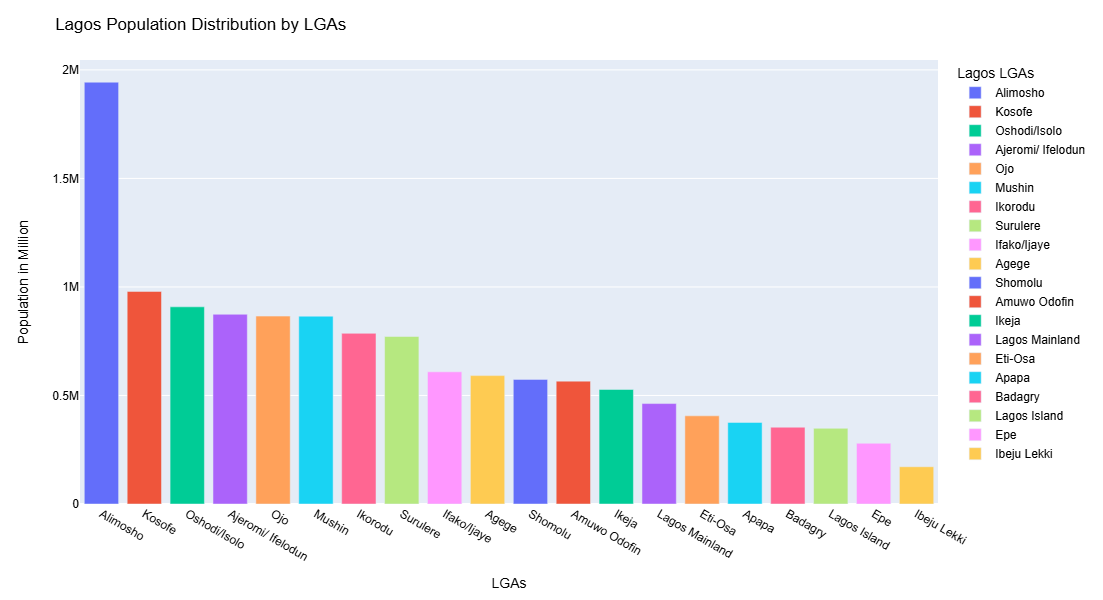

In [14]:
fig = px.bar(lag_pop, x='ADM2_NAME', y='Population', color='ADM2_NAME', height=600)

fig.update_layout(
    title="Lagos Population Distribution by LGAs",
    xaxis_title="LGAs",
    yaxis_title="Population in Million",
    legend_title="Lagos LGAs",
    font=dict(
        family="Arial",
        size=12,
        color="Black"
    )
)

fig.show()

#### Importing GRID3 Nigeria Health Facilities shapefile for Analysis

In [15]:
gpd_data = geemap.shp_to_gdf('GRID3_NGA_-_Health_Facilities/GRID3_NGA_-_Health_Facilities_.shp')
gpd_data.head()

FID                              globalid  uniq_id   timestamp  \
0    1  af719462-abfd-4f47-9dc3-0987164e75ac        1  2020-07-04   
1    2  a29b0328-d844-4358-b0ab-2e120b8fb30f        2  2020-07-04   
2    3  b685b769-5c83-4f83-a182-00e7e1b777d8        3  2020-07-04   
3    4  78e64f7a-cbb8-4357-9e64-a7e502534527        4  2020-07-04   
4    5  409c97ce-7490-4dc2-a8f8-2b8d53ad2b12        5  2020-07-04   

             editor   latitude  longitude        wardname wardcode  \
0    tosin.williams  11.822320  13.148320      Maisandari    12413   
1  mokobia.chidinma  11.821615  13.147176      Maisandari    12413   
2  mokobia.chidinma  10.707092  12.816284           Ngohi    10207   
3    tosin.williams  10.615220  12.181628       Galdimari    10503   
4    tosin.williams  10.759527  13.313358  Ngurthavu Kopa    10209   

      lganame  ...  updated_on accessblty            func_stats  \
0   Maiduguri  ...  2019-03-01       None               Unknown   
1   Maiduguri  ...  2019-03-01    Unknown            Functional   
2  Askira Uba  ...  2019-03-01       None  Partially Functional   
3         Biu  ...  2019-03-01    Unknown        Not Functional   
4  Askira Uba  ...  2019-03-01    Unknown  Partially Functional   

                category                                       ownership  \
0  Primary Health Center                                         Private   
1  Primary Health Center  National Primary Healthcare Development Agency   
2  Primary Health Center     State Primary Healthcare Development Agency   
3  Primary Health Center                                          Others   
4             Dispensary                                          Others   

      type            source                  alt_name  \
0  Primary         eHA Polio              Nursing Home   
1  Primary  Measles Campaign              Nursing Home   
2  Primary         eHA Polio                      None   
3  Primary         eHA Polio  Mandara Girau Dispensary   
4  Primary         eHA Polio                      None   

                   prmry_name                   geometry  
0          G R A Nursing Home  POINT (13.14832 11.82232)  
1       Gishili Health Center  POINT (13.14718 11.82161)  
2  Lehobi Primary Health Care  POINT (12.81628 10.70709)  
3              Dugja Idp Camp  POINT (12.18163 10.61522)  
4   Kopa Maikudiri Dispensary  POINT (13.31336 10.75953)  

[5 rows x 23 columns]

In [16]:
gpd_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 46146 entries, 0 to 46145
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         46146 non-null  int64   
 1   globalid    46146 non-null  object  
 2   uniq_id     46146 non-null  int64   
 3   timestamp   46146 non-null  object  
 4   editor      46146 non-null  object  
 5   latitude    46146 non-null  float64 
 6   longitude   46146 non-null  float64 
 7   wardname    46146 non-null  object  
 8   wardcode    46146 non-null  object  
 9   lganame     46146 non-null  object  
 10  lgacode     46146 non-null  object  
 11  statename   46146 non-null  object  
 12  statecode   46146 non-null  object  
 13  updated_on  45923 non-null  object  
 14  accessblty  134 non-null    object  
 15  func_stats  46146 non-null  object  
 16  category    46112 non-null  object  
 17  ownership   46146 non-null  object  
 18  type        46146 non-null  object  
 

In [17]:
# Checking for unique value to filter for health facilities of only the study area

gpd_data.statecode.unique()

array(['BR', 'BA', 'OG', 'ZA', 'KO', 'YO', 'AB', 'EB', 'ED', 'EK', 'IM',
       'KB', 'LA', 'NI', 'RI', 'AD', 'BE', 'OY', 'KW', 'AN', 'OS', 'SO',
       'EN', 'GO', 'BY', 'ON', 'PL', 'KD', 'DE', 'NA', 'KT', 'JI', 'CR',
       'FC', 'TA', 'KN', 'AK'], dtype=object)

In [18]:
# filtering for Lagos only health facilities
lag_data = gpd_data[gpd_data.statecode == 'LA']
lag_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2320 entries, 1004 to 43283
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         2320 non-null   int64   
 1   globalid    2320 non-null   object  
 2   uniq_id     2320 non-null   int64   
 3   timestamp   2320 non-null   object  
 4   editor      2320 non-null   object  
 5   latitude    2320 non-null   float64 
 6   longitude   2320 non-null   float64 
 7   wardname    2320 non-null   object  
 8   wardcode    2320 non-null   object  
 9   lganame     2320 non-null   object  
 10  lgacode     2320 non-null   object  
 11  statename   2320 non-null   object  
 12  statecode   2320 non-null   object  
 13  updated_on  2320 non-null   object  
 14  accessblty  0 non-null      object  
 15  func_stats  2320 non-null   object  
 16  category    2320 non-null   object  
 17  ownership   2320 non-null   object  
 18  type        2320 non-null   object  

In [19]:
# Dropping noise columns

lag_data = lag_data.drop(['globalid', 'uniq_id', 'editor', 'accessblty', 'alt_name', 'wardname', 'wardcode', 'timestamp', 'updated_on'], axis= 1)

In [20]:
print(lag_data.shape)
lag_data.head()

(2320, 14)


FID  latitude  longitude       lganame lgacode statename statecode  \
1004  1005  6.525300   3.294510  Oshodi/Isolo   25016     Lagos        LA   
1079  1080  6.463258   3.392398  Lagos Island   25020     Lagos        LA   
1098  1099  6.440638   3.901619   Ibeju Lekki   25009     Lagos        LA   
1104  1105  6.570659   3.287898      Alimosho   25003     Lagos        LA   
1105  1106  6.418275   3.144870           Ojo   25015     Lagos        LA   

      func_stats               category              ownership     type  \
1004     Unknown               Pharmacy                Private  Primary   
1079  Functional  Primary Health Center  Local Government Area  Primary   
1098  Functional  Primary Health Center  Local Government Area  Primary   
1104  Functional  Primary Health Center  Local Government Area  Primary   
1105  Functional  Primary Health Center  Local Government Area  Primary   

     source                                         prmry_name  \
1004  OSGOF                                      Peak Pharmacy   
1079   GRID      Oba Adeyinka Oyekan 11 Memorial Health Center   
1098   GRID                      Orimedu Primary Health Center   
1104   GRID  Alimosho Local Goverment Egbe Idimu Lcda Healt...   
1105   GRID     Irewe Primary Care Health Center Osulu Kingdom   

                     geometry  
1004  POINT (3.29451 6.52530)  
1079  POINT (3.39240 6.46326)  
1098  POINT (3.90162 6.44064)  
1104  POINT (3.28790 6.57066)  
1105  POINT (3.14487 6.41827)

In [21]:
lag_data.category.unique()

array(['Pharmacy', 'Primary Health Center', 'Laboratory',
       'Educational Clinic', 'Veterinary Clinic', 'Private Non Profit',
       'Specialist Hospital', 'Maternity Home',
       'Military and Paramilitary Clinic', 'Medical Center',
       'Federal Staff Clinic', 'General Hospital', 'Teaching Hospital',
       'Dispensary', 'Federal Medical Center', 'Cottage Hospital',
       'Community Health Center'], dtype=object)

In [22]:
# Exploring healthcare facility types in Lagos

category = lag_data.groupby(['category'])['prmry_name'].count().reset_index()
category = category.sort_values('prmry_name', ascending=False)
category

category  prmry_name
12             Primary Health Center        1482
8                     Maternity Home         236
9                     Medical Center         232
14               Specialist Hospital         118
13                Private Non Profit          85
7                         Laboratory          71
2                         Dispensary          30
6                   General Hospital          19
11                          Pharmacy          14
10  Military and Paramilitary Clinic          10
3                 Educational Clinic           7
4             Federal Medical Center           6
5               Federal Staff Clinic           4
1                   Cottage Hospital           3
15                 Teaching Hospital           1
0            Community Health Center           1
16                 Veterinary Clinic           1

In [23]:
fc = geemap.gdf_to_ee(lag_data)

categories = ['Pharmacy', 'Primary Health Center', 'Laboratory', 'Educational Clinic', 'Veterinary Clinic', 'Private Non Profit',
         'Specialist Hospital', 'Maternity Home','Military and Paramilitary Clinic', 'Medical Center','Federal Staff Clinic',
         'General Hospital', 'Teaching Hospital','Dispensary', 'Federal Medical Center', 'Cottage Hospital','Community Health Center']

colors = ['E31A1C', 'FF7F00', '6A3D9A', '000000', 'FDBF6F', '229A00','593704','BC80BD','0565A6','5CA2D1',
          'B28653','006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5','007C88']

styled_fc = geemap.ee_vector_style(fc, column="category", labels=categories, color=colors)

In [24]:
Map = geemap.Map()
Map.addLayer(styled_fc, {}, 'Lagos Healthcare')
Map.add_legend(title="Healthcare Categories", labels=categories, colors=colors)
Map.addLayer(lag.style(**vis), {}, 'Lagos LGAs')
Map.centerObject(lag, zoom=10)
Map

Map(center=[6.527190792712951, 3.5654098424237106], controls=(WidgetControl(options=['position', 'transparent_…

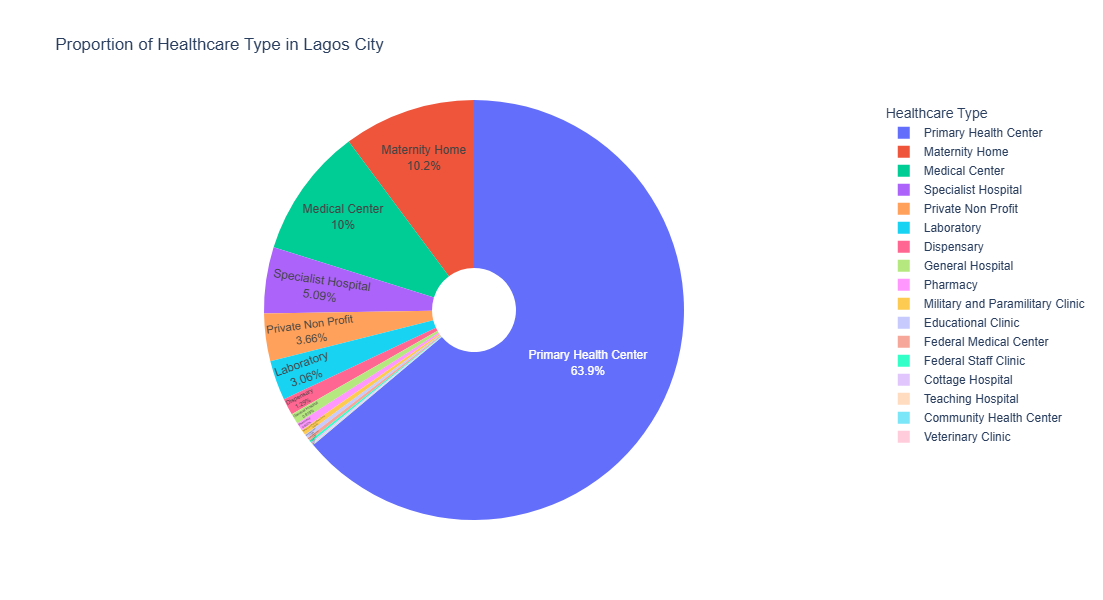

In [25]:
# Visualizing variation in healthcare types in Lagos

fig = px.pie(category, values='prmry_name', names='category', hole=0.2, width=600, height=600,
             title="Proportion of Healthcare Type in Lagos City")

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.update_layout(
    legend_title = 'Healthcare Type',
    # width=600,
    # height=600,
        font=dict(
        family="Arial",
        size=12
    )
)

fig.show()

In [26]:
lag_data.groupby(['func_stats'])['prmry_name'].count()

func_stats
Functional    2165
Unknown        155
Name: prmry_name, dtype: int64

In [27]:
# Dropping veterinary clinic as it do not tally with the theme of study

lag_data = lag_data[lag_data.category != 'Veterinary Clinic']

In [28]:
# Converting data to dataframe to join to population dataset
lag_df = geemap.gdf_to_df(lag_data)
print(lag_df.shape)
lag_df.head()

(2319, 13)


FID  latitude  longitude       lganame lgacode statename statecode  \
1004  1005  6.525300   3.294510  Oshodi/Isolo   25016     Lagos        LA   
1079  1080  6.463258   3.392398  Lagos Island   25020     Lagos        LA   
1098  1099  6.440638   3.901619   Ibeju Lekki   25009     Lagos        LA   
1104  1105  6.570659   3.287898      Alimosho   25003     Lagos        LA   
1105  1106  6.418275   3.144870           Ojo   25015     Lagos        LA   

      func_stats               category              ownership     type  \
1004     Unknown               Pharmacy                Private  Primary   
1079  Functional  Primary Health Center  Local Government Area  Primary   
1098  Functional  Primary Health Center  Local Government Area  Primary   
1104  Functional  Primary Health Center  Local Government Area  Primary   
1105  Functional  Primary Health Center  Local Government Area  Primary   

     source                                         prmry_name  
1004  OSGOF                                      Peak Pharmacy  
1079   GRID      Oba Adeyinka Oyekan 11 Memorial Health Center  
1098   GRID                      Orimedu Primary Health Center  
1104   GRID  Alimosho Local Goverment Egbe Idimu Lcda Healt...  
1105   GRID     Irewe Primary Care Health Center Osulu Kingdom

In [29]:
# Selecting data to join (i.e, healthcare facilities count by LGAs and the LGA names)

lag_df2 = lag_df.groupby(['lganame'])['prmry_name'].count().reset_index()
lag_df2.head()

lganame  prmry_name
0             Agege          80
1  Ajeromi/Ifelodun          80
2          Alimosho         215
3      Amuwo Odofin         102
4             Apapa          58

#### Assessing healthcare facilities by LGAs in Lagos City

In [30]:
#Exploring keys to join the population and healthcare datasets

lag_pop_gdf['ADM2_NAME'].sort_values(ascending=True)

2                 Agege
13    Ajeromi/ Ifelodun
1              Alimosho
12         Amuwo Odofin
14                Apapa
17              Badagry
18                  Epe
19              Eti-Osa
16          Ibeju Lekki
0           Ifako/Ijaye
3                 Ikeja
15              Ikorodu
4                Kosofe
5          Lagos Island
10       Lagos Mainland
8                Mushin
9                   Ojo
6          Oshodi/Isolo
7               Shomolu
11             Surulere
Name: ADM2_NAME, dtype: object

In [31]:
lag_df2.lganame.unique()

array(['Agege', 'Ajeromi/Ifelodun', 'Alimosho', 'Amuwo Odofin', 'Apapa',
       'Badagry', 'Epe', 'Eti Osa', 'Ibeju Lekki', 'Ifako/Ijaye', 'Ikeja',
       'Ikorodu', 'Kosofe', 'Lagos Island', 'Lagos Mainland', 'Mushin',
       'Ojo', 'Oshodi/Isolo', 'Shomolu', 'Surulere'], dtype=object)

In [32]:
# Renaming 2 LGAs' names in a table after determining during exploration that different naming conventions were used for them

lag_df2['lganame'] = lag_df2['lganame'].replace({'Ajeromi/Ifelodun': 'Ajeromi/ Ifelodun', 'Eti Osa': 'Eti-Osa'})
lag_df2.lganame.unique()

array(['Agege', 'Ajeromi/ Ifelodun', 'Alimosho', 'Amuwo Odofin', 'Apapa',
       'Badagry', 'Epe', 'Eti-Osa', 'Ibeju Lekki', 'Ifako/Ijaye', 'Ikeja',
       'Ikorodu', 'Kosofe', 'Lagos Island', 'Lagos Mainland', 'Mushin',
       'Ojo', 'Oshodi/Isolo', 'Shomolu', 'Surulere'], dtype=object)

In [33]:
#Joining healthcare facilities table to Population table

gpd_join = lag_pop_gdf.merge(lag_df2, how="left", left_on='ADM2_NAME', right_on='lganame')

In [34]:
gpd_join = gpd_join.rename(columns={'prmry_name':'no_healthcare_center'})
gpd_join.head(3)

geometry  ADM0_CODE ADM0_NAME  \
0  POLYGON ((3.25167 6.70511, 3.25827 6.69564, 3....        182   Nigeria   
1  POLYGON ((3.18644 6.54967, 3.18829 6.54820, 3....        182   Nigeria   
2  POLYGON ((3.28665 6.65345, 3.28724 6.64699, 3....        182   Nigeria   

   ADM1_CODE ADM1_NAME  ADM2_CODE    ADM2_NAME DISP_AREA  EXP2_YEAR  \
0       2230     Lagos     191284  Ifako/Ijaye        NO       3000   
1       2230     Lagos     191285     Alimosho        NO       3000   
2       2230     Lagos     191287        Agege        NO       3000   

         STATUS  STR2_YEAR  Shape_Area  Shape_Leng    Population  category  \
0  Member State       1999    0.002737    0.253387  6.089432e+05         3   
1  Member State       1999    0.012055    0.498507  1.943306e+06         5   
2  Member State       1999    0.001350    0.169576  5.915347e+05         3   

     color      lganame  no_healthcare_center  
0  #ffffbf  Ifako/Ijaye                   122  
1  #9e0142     Alimosho                   215  
2  #ffffbf        Agege                    80

In [35]:
# Visualizing Healthcare centers distribution in the City of Lagos

m = geemap.Map()

map.addLayer(lag.style(**vis), {}, 'Lagos LGAs')

m.add_data(
    gpd_join,
    column="no_healthcare_center",
    scheme="NaturalBreaks",
    cmap="PuBuGn",
    legend_title="Number of Healthcare Centers",
    layer_name="Pop classes",
    info_mode=None,
)

m.add_labels(
    data=lag,
    column="ADM2_NAME",
    font_size="6pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=False,
)

text2 = 'Data Source: GRID3, FAO UN, & NASA SEDAC: GPWv411'
m.add_text(text2, position='bottomleft', fontsize=10)

m.centerObject(lag, zoom=10)
m

Map(center=[6.527190792712951, 3.5654098424237106], controls=(WidgetControl(options=['position', 'transparent_…

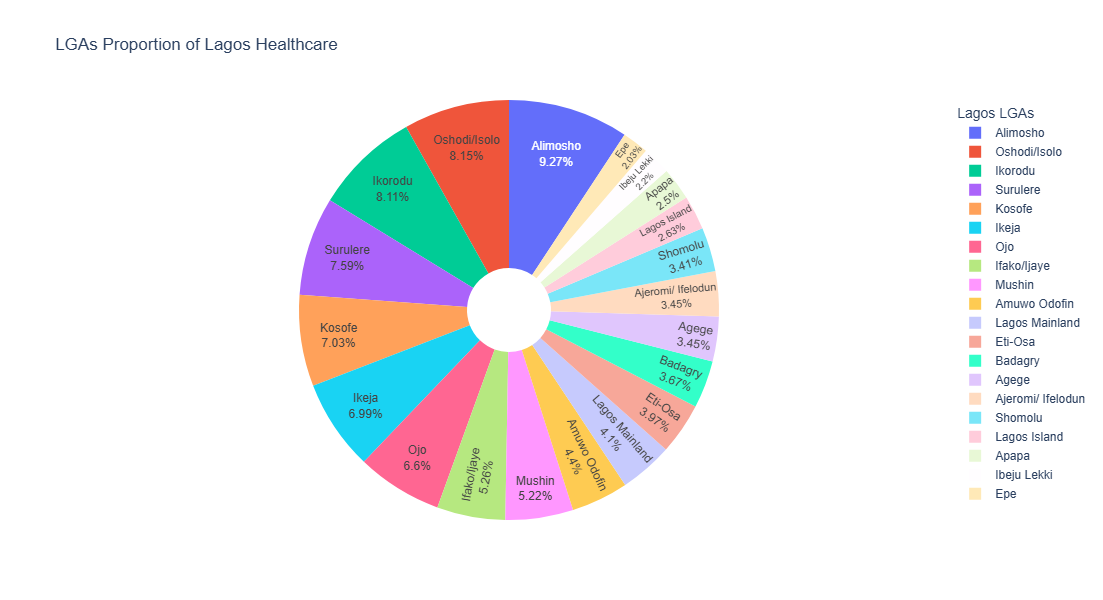

In [36]:
fig = px.pie(gpd_join, values='no_healthcare_center', names='ADM2_NAME', hole=0.2, width=600, height=600,
             title="LGAs Proportion of Lagos Healthcare")

fig.update_traces(textposition='inside', textinfo='percent+label')

fig.update_layout(
    legend_title = 'Lagos LGAs',
        font=dict(
        family="Arial",
        size=12
    )
)

fig.show()

#### The healthcare coverage model, as defined by [USAID](https://www.data4impactproject.org/prh/health-systems/health-system-strengthening/number-and-distribution-of-health-facilities-per-10000-population/), is adopted to determine the accessibility of healthcare facilities in Lagos City. Accessibility and coverage are defined as a maximum of 10,000 people utilizing a healthcare facility in a designated area.

In [37]:
import numpy as np
gpd_join['healthcare_access'] = np.round(gpd_join.no_healthcare_center / (gpd_join.Population * 0.0001), decimals=1)
gpd_join.head(3)

geometry  ADM0_CODE ADM0_NAME  \
0  POLYGON ((3.25167 6.70511, 3.25827 6.69564, 3....        182   Nigeria   
1  POLYGON ((3.18644 6.54967, 3.18829 6.54820, 3....        182   Nigeria   
2  POLYGON ((3.28665 6.65345, 3.28724 6.64699, 3....        182   Nigeria   

   ADM1_CODE ADM1_NAME  ADM2_CODE    ADM2_NAME DISP_AREA  EXP2_YEAR  \
0       2230     Lagos     191284  Ifako/Ijaye        NO       3000   
1       2230     Lagos     191285     Alimosho        NO       3000   
2       2230     Lagos     191287        Agege        NO       3000   

         STATUS  STR2_YEAR  Shape_Area  Shape_Leng    Population  category  \
0  Member State       1999    0.002737    0.253387  6.089432e+05         3   
1  Member State       1999    0.012055    0.498507  1.943306e+06         5   
2  Member State       1999    0.001350    0.169576  5.915347e+05         2   

     color      lganame  no_healthcare_center  healthcare_access  
0  #67a9cf  Ifako/Ijaye                   122                2.0  
1  #014636     Alimosho                   215                1.1  
2  #d0d1e6        Agege                    80                1.4

In [38]:
gpd_join = gpd_join.drop(['ADM0_CODE', 'ADM1_CODE', 'ADM2_CODE', 'DISP_AREA', 'STATUS', 'STR2_YEAR', 'category', 'color', 'lganame', 'EXP2_YEAR'], axis= 1)

In [39]:
m = geemap.Map()

map.addLayer(lag.style(**vis), {}, 'Lagos LGAs')

m.add_data(
    gpd_join,
    column="healthcare_access",
    scheme="NaturalBreaks",
    cmap="PuBu",
    legend_title="Healthcare Coverage/10k_pple",
    layer_name="Healthcare Dist",
    info_mode='on_click',
)

m.add_labels(
    data=lag,
    column="ADM2_NAME",
    font_size="6pt",
    font_color="black",
    font_family="arial",
    font_weight="bold",
    draggable=False,
)

text2 = 'Data Source: GRID3, FAO UN, & NASA SEDAC: GPWv411'
m.add_text(text2, position='bottomleft', fontsize=10)

m.centerObject(lag, zoom=10)
m

Map(center=[6.527190792712951, 3.5654098424237106], controls=(WidgetControl(options=['position', 'transparent_…

In [40]:
gpd_hcr = gpd_join.sort_values('healthcare_access', ascending=False)

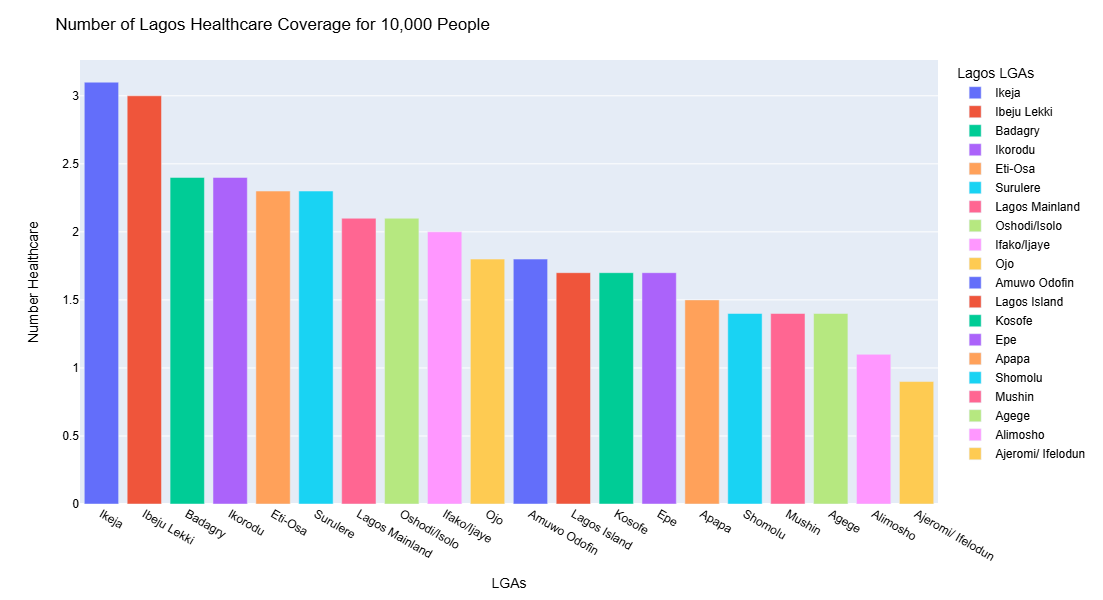

In [41]:
fig = px.bar(gpd_hcr, x='ADM2_NAME', y='healthcare_access', color='ADM2_NAME', height=600)

fig.update_layout(
    title="Number of Lagos Healthcare Coverage for 10,000 People",
    xaxis_title="LGAs",
    yaxis_title="Number Healthcare",
    legend_title="Lagos LGAs",
    font=dict(
        family="Arial",
        size=12,
        color="Black"
    )
)

fig.show()

In [42]:
lag_care = geemap.gdf_to_ee(gpd_join)
geemap.ee_export_vector(lag_care,'lag_healthcare.shp')

Generating URL ...
Please wait ...
Data downloaded to C:\Users\User\Downloads\Learning\healthcare_distribution\lag_healthcare.shp


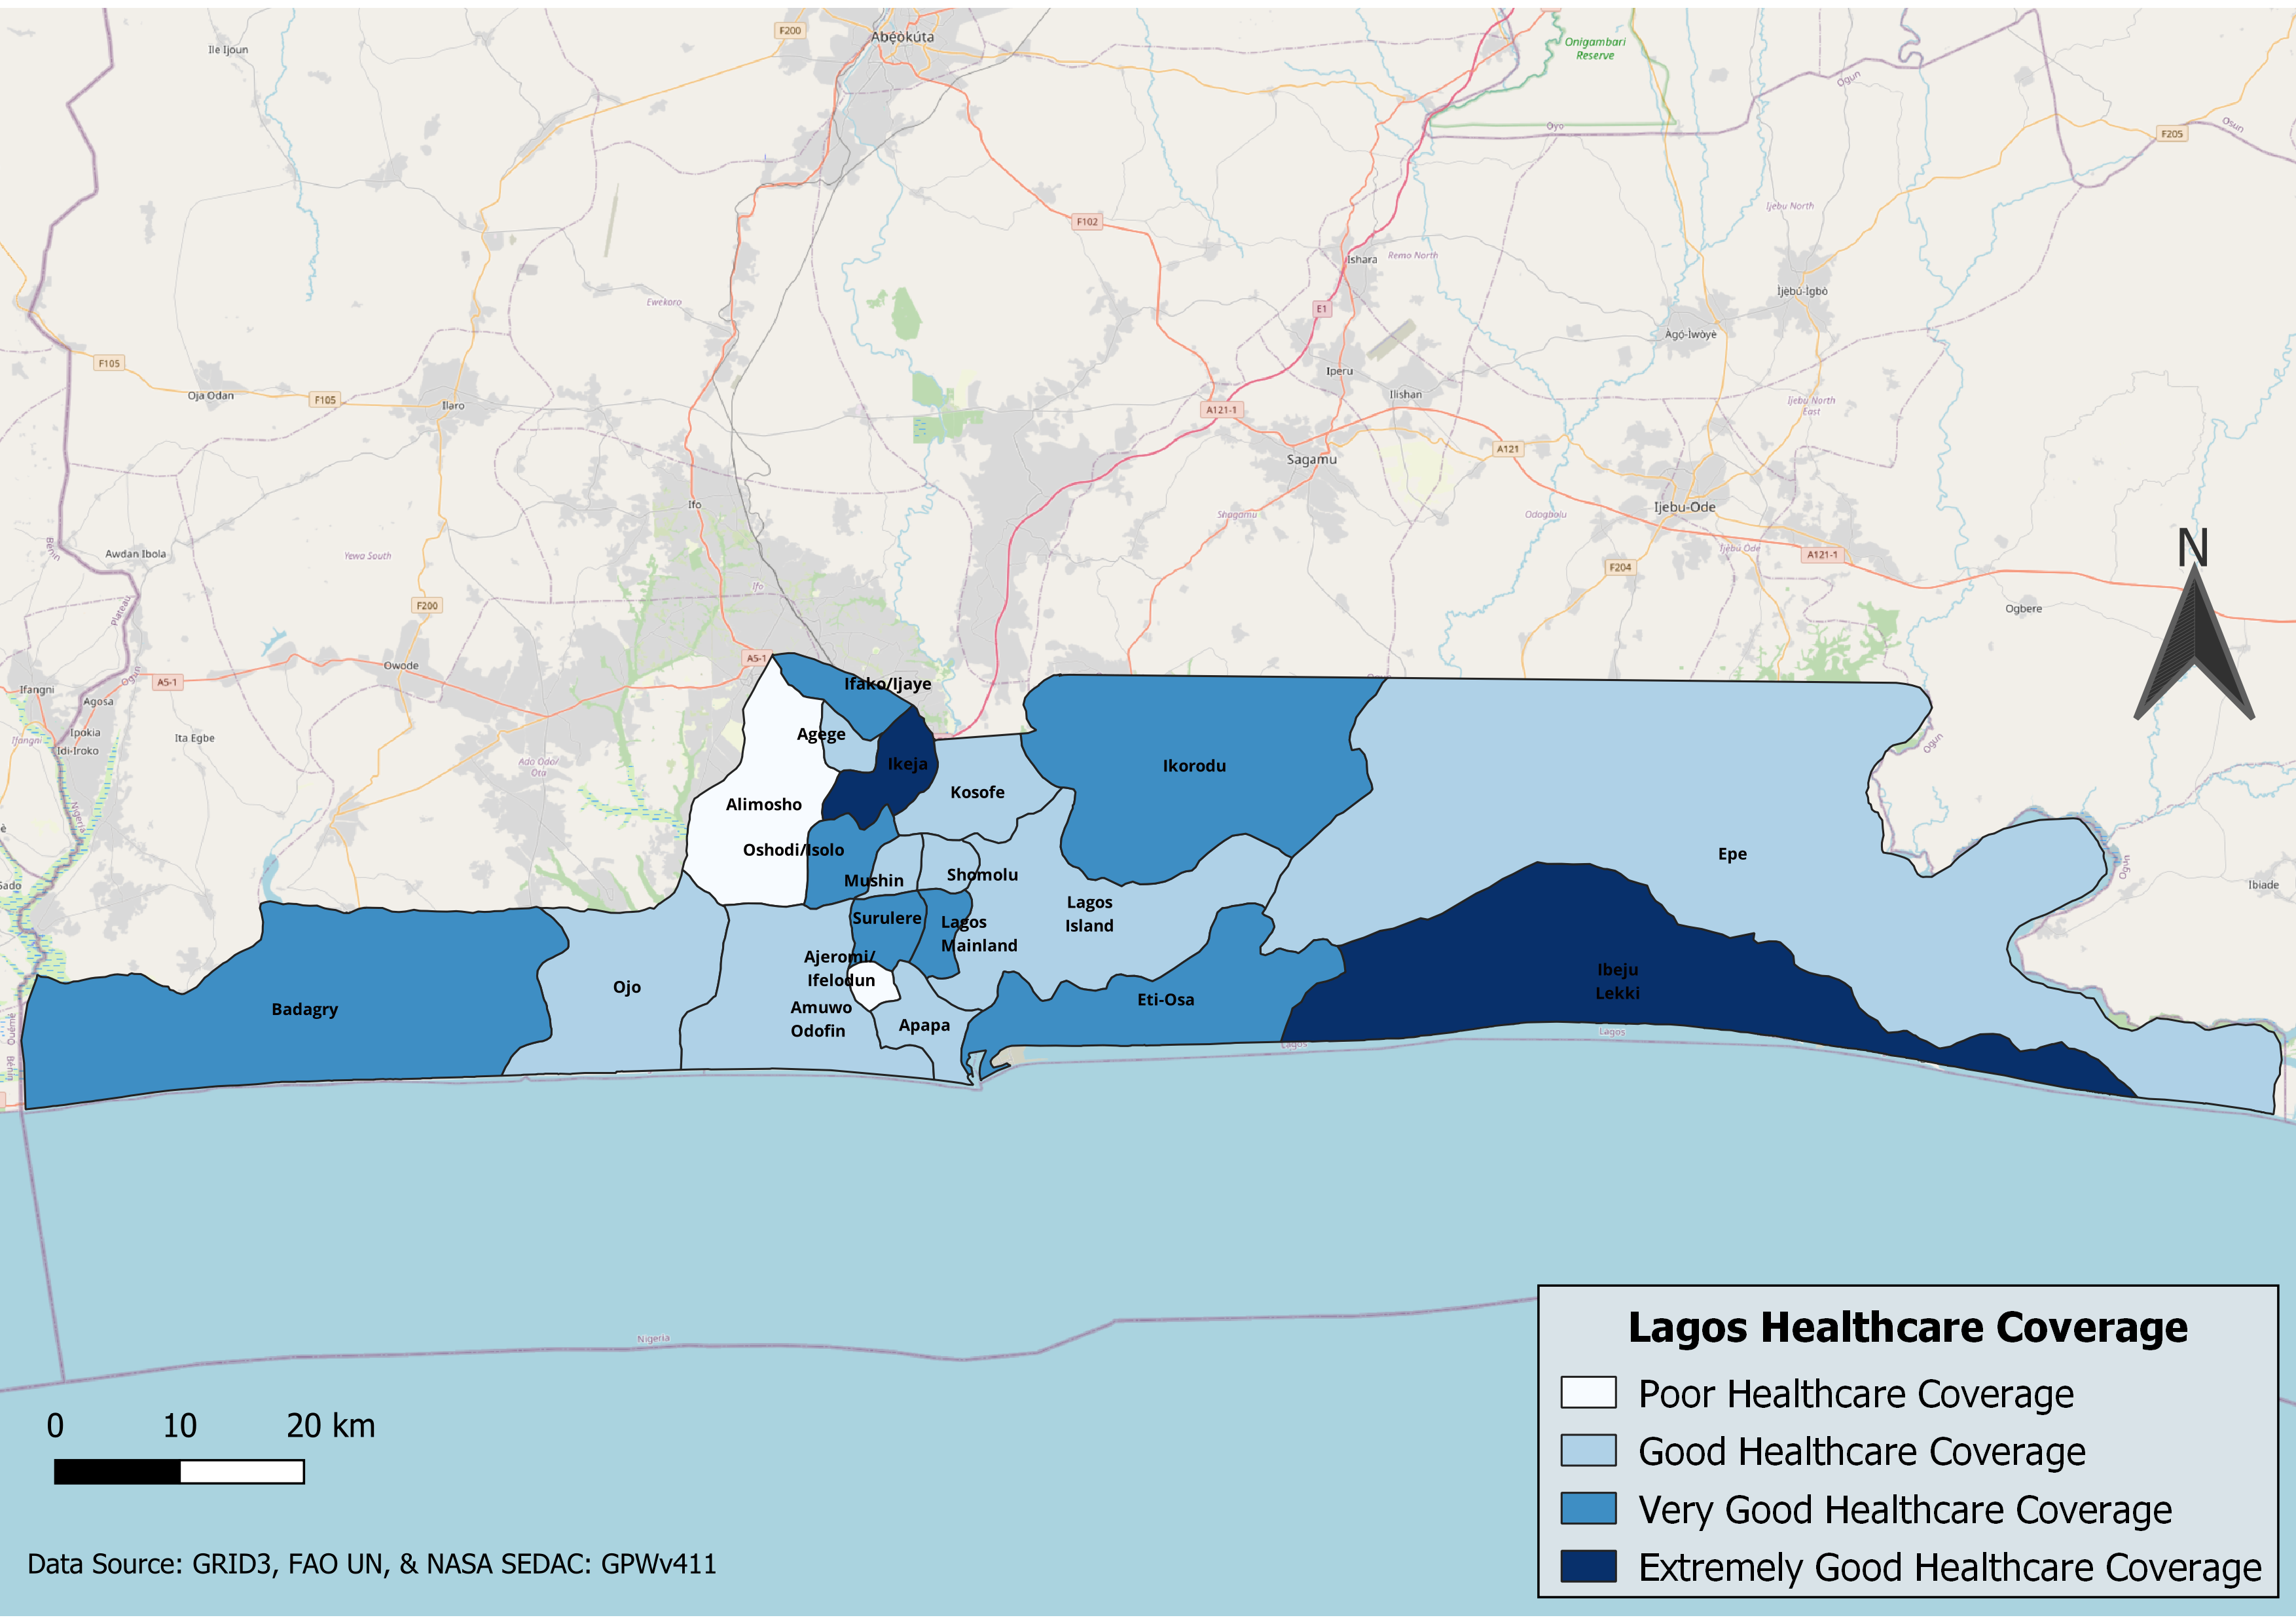

In [1]:
from IPython.display import Image, display
display(Image(filename='healthcare.png', embed=True))

## Result and Discussion

This study provides a comprehensive overview of the distribution of healthcare centers and accessibility in Lagos. It's a crucial step towards addressing the issue of healthcare facility availability, ensuring that no area is left underserved. This, in turn, will significantly contribute to the realization of Universal Health Coverage (UHC) in the city.<br>
<br>The findings from this study are of significant importance, revealing that Ikeja and Ibeju Lekki boast the best healthcare coverage, with a rate above 2.4. This rate, which refers to the number of healthcare centers per 10,000 people, is a crucial metric for understanding healthcare accessibility. LGAs such as Badagry, Eti-Osa, Surulere, Lagos Mainland, Oshodi, and Ikorodu also demonstrate commendable healthcare delivery coverage, with a rate of over two healthcare centers to 10,000 people. However, Ajeromi/Ifelodun and Alimosho have the least healthcare coverage, with a rate of one or fewer healthcare coverage per 10,000 people.<br>
<br>This research provides valuable insights for planning the establishment and provision of healthcare facilities. By ensuring optimal and equitable distribution in setting up and establishing healthcare centers, the ministries can effectively address the population's healthcare needs.